In [2]:
import numpy as np
import matplotlib.pylab as plt
from matplotlib.ticker import MultipleLocator
%matplotlib inline

In [3]:
#Load data -- easier to take P and z from model 
z = np.load("../data/small_domain_micro_z.dat")[0, 0, 9:] #900hPa and above
press = np.load( "../data/small_domain_micro_press.dat")[0, 0, 9:]
p = len( press )

In [4]:
#Define constants
g = 9.8
cp = 1005.
Lv = 2.5 * 10. ** 6
#Dry lapse-rate:
gam_d = -g / cp 
Rd = 287.058
Rv = 461.

#Parameters:
Ts = [288., 290., 292]
eps = [0., 0.5, 1.5]
RH = 0.8

In [5]:
#Some functions:
def deriv( y, x ):

    l = len( y )
    dy_dx = np.zeros( l )
    for i in range( l ):
        if i == 0:
            dy_dx[i] = (y[1] - y[0]) / (x[1] - x[0] )
        elif i == l - 1:
            dy_dx[i] = (y[l - 1] - y[l - 2]) / (x[l - 1] - x[l - 2] )
        else:
            dy_dx[i] = (y[i + 1] - y[i - 1]) / (x[i + 1] - x[i - 1] )
    return dy_dx

def make_axis( ax ):

    ax.tick_params( axis = 'x', which = 'both', bottom="on", top = "off", labelbottom = "on", direction = 'out')                  
    ax.tick_params( axis = 'y', which = 'both', bottom="off", top="off",  labelbottom="off", left="on", right="off", labelleft="on", direction = 'out')                                                                                        

    ax.tick_params(length = 5, which = 'both')

    ax.spines["top"].set_visible(False)    
    ax.spines["right"].set_visible(False)    

    plt.ylabel("Pressure [hPa]", fontsize = 14)

    majorLocator = MultipleLocator(100)
    minorLocator = MultipleLocator(25)
    ax.yaxis.set_major_locator(majorLocator)
    ax.yaxis.set_minor_locator(minorLocator)

    plt.ylim([905., 400.])
    
    return ax

In [6]:
T_e = np.zeros( ( ( 3, 3, p ) ) ) #Entraining plume temperatures
qc = np.zeros( ( ( 3, 3, p ) ) )

for k in range( 3 ):
    for j in range( 3 ):
        T = np.zeros( p )
        T[0] = Ts[k]

        del_T = np.zeros( p )
        gam = np.zeros( p - 1)


        qsat = np.zeros( p )
        for i in range(  p ):
            #Calculate saturation vapor pressure
            if i > 0:
                qsat[i] = (0.61094 * np.exp( 17.625 * (T[i - 1] - 273.15) / ( (T[i - 1] - 273.15) + 243.04) ) ) * 1000.
                qsat[i] = 0.622 * qsat[i] / (press[i - 1] * 100. - qsat[i])
            else:
                qsat[i] = (0.61094 * np.exp( 17.625 * (T[i] - 273.15) / ( ( T[i] - 273.15) + 243.04) ) ) * 1000.
                qsat[i] = 0.622 * qsat[i] / (press[i] * 100. - qsat[i] )

            #Calculate moist adiabat
            if i > 0:
                gam[i - 1] = gam_d * (1. + Lv * qsat[i] / Rd / T[i - 1]) / (1. + Lv ** 2 * qsat[i] / Rv / T[i - 1] ** 2 / cp)
                T[i] = T[i - 1] + (z[i] - z[i- 1]) * gam[i - 1]

        #Now calculate difference due to entrainment, using Singh and O'Gorman framework        
        for i in range( 1, p ):
            del_T[i] = eps[j] / z[i] * (1. - RH ) / (1. + Lv / Rv / T[i] ** 2 * Lv * qsat[i] / cp ) * np.trapz( Lv / cp * qsat[:i], z[:i] )

        #The entraining profile:
        T_e[k, j] = T - del_T
        #The entraining lapse-rates:
        gam_e = deriv( T_e[k, j], z )	

        #Now calculate cloud condensate mixing ratios
        for i in range( 2, p ):
            qc[k, j, i] = qc[k, j, i - 1] + (z[i] - z[i - 1]) * ( (cp * gam_e[i] + g ) / Lv - eps[j] / z[i - 1] * qc[k, j, i - 1] )

/home/nick/.local/lib/python2.7/site-packages/IPython/kernel/__main__.py:47: RuntimeWarning: invalid value encountered in divide
/home/nick/.local/lib/python2.7/site-packages/IPython/kernel/__main__.py:48: RuntimeWarning: invalid value encountered in divide
/home/nick/.local/lib/python2.7/site-packages/IPython/kernel/__main__.py:49: RuntimeWarning: invalid value encountered in divide


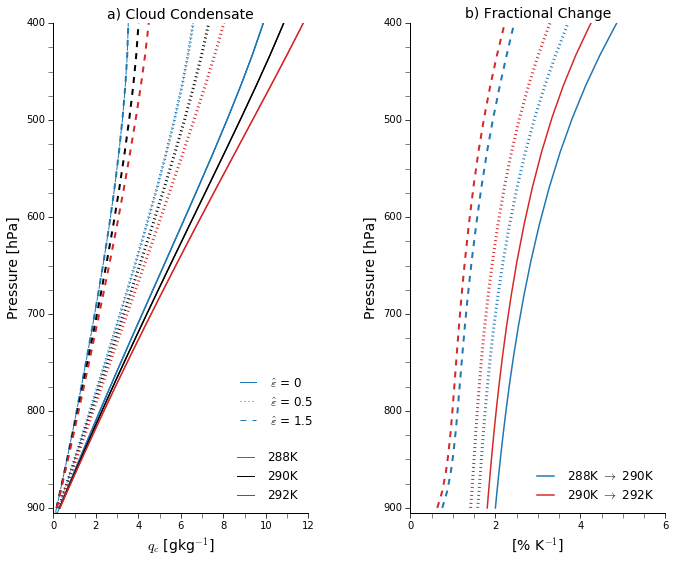

In [7]:
#Plot!

cs = [(31 / 255., 119 / 255., 180 / 255.), (0. / 255., 0 / 255., 0 / 255.), (214 / 255., 39 / 255., 40 / 255.), (255 / 255., 127 / 255., 14 / 255.) ]
fig = plt.figure( figsize = (10, 8) )
plt.subplots_adjust(left = 0.12, right = 0.97, bottom = 0.1, top = 0.95, hspace = 0.45, wspace = 0.4)

ax = plt.subplot(1, 2, 1)
plt.title("a) Cloud Condensate", fontsize = 14 )

plot_lines = []

l1, = plt.plot( qc[0, 0, :] * 1000., press[:], color = cs[0] )
l2, = plt.plot( qc[0, 1, :] * 1000., press[:], ':', color = cs[0] )
l3, = plt.plot( qc[0, 2, :] * 1000., press[:], '--', color = cs[0] )

plot_lines.append([l1, l2, l3])

legend1 = plt.legend([l1, l2, l3], ["$\hat{\\varepsilon}$ = 0", "$\hat{\\varepsilon}$ = 0.5", "$\hat{\\varepsilon}$ = 1.5"], bbox_to_anchor=(1.06, 0.3), frameon = False )

plot_lines = []

for j in range( 3 ):
    l1, = plt.plot( qc[j, 0, 2:] * 1000., press[2:], color = cs[j] )
    plot_lines.append([l1])
plt.legend([l[0] for l in plot_lines], ["288K", "290K", "292K"], loc = "lower right", frameon = False )
plt.gca().add_artist( legend1 )

for j in range( 3 ):
    plt.plot( qc[j, 0, 2:] * 1000., press[2:], color = cs[j], linewidth = 1.5 )
    plt.plot( qc[j, 1, 2:] * 1000., press[2:], ":", color = cs[j], linewidth = 3 )
    plt.plot( qc[j, 2, 2:] * 1000., press[2:],  "--", color = cs[j], linewidth = 2 )

make_axis( ax )

plt.xlabel("$q_c$ [gkg$^{-1}$]", fontsize = 14)
plt.xlim([0., 12.])
majorLocator = MultipleLocator(2)
minorLocator = MultipleLocator(1)
ax.xaxis.set_major_locator(majorLocator)
ax.xaxis.set_minor_locator(minorLocator)

ax = plt.subplot(1, 2, 2)
plt.title("b) Fractional Change", fontsize = 14 )
plot_lines = []
k = [0, 2]
for i in range( 1, 3 ):
    l1, = plt.plot( (qc[i, 0, :] - qc[i - 1, 0, :]) / qc[i - 1, 0, :] * 50., press[:], color = cs[k[i - 1]], linewidth = 1.5 )
    l2, = plt.plot( (qc[i, 1, :] - qc[i - 1, 1, :]) / qc[i - 1, 0, :] * 50., press[:], ':', color = cs[k[i - 1]], linewidth = 3 )
    l3, = plt.plot( (qc[i, 2, :] - qc[i - 1, 2, :]) / qc[i - 1, 0, :] * 50., press[:], '--', color = cs[k[i - 1]], linewidth = 2 )
    plot_lines.append([l1, l2, l3])

legend1 = plt.legend([l[0] for l in plot_lines], ["288K $\\rightarrow$ 290K", "290K $\\rightarrow$ 292K"], loc = "lower right", frameon = False )

make_axis( ax )
plt.xlabel( "[% K$^{-1}$]", fontsize = 14 )
plt.xlim([0., 6.])
majorLocator = MultipleLocator(2)
minorLocator = MultipleLocator(0.5)
ax.xaxis.set_major_locator(majorLocator)
ax.xaxis.set_minor_locator(minorLocator)

plt.show()